# ResNet on CIFAR-10

## Imports

In [1]:
%%capture
!pip install pytorch-ignite
!pip install fvcore

In [2]:
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import seaborn as sns
import argparse
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import _LRScheduler

import ignite.metrics
import ignite.contrib.handlers
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor
from ignite.contrib.handlers import ProgressBar

from PIL import ImageFilter, ImageOps, Image
import random

import warnings
warnings.filterwarnings("ignore")

## Parser

In [102]:
def get_args_parser():
    parser = argparse.ArgumentParser('ResNEt for CIFAR-10', add_help=False)
    parser.add_argument('--dir', type=str, default='./data',
                    help='Data directory')
    parser.add_argument('--num_classes', type=int, default=10, choices=[10, 100, 196, 1000],
                    help='Dataset name')

    parser.add_argument('--image_size', default=32, type=int, help=""" Size of input image. """)
    parser.add_argument('--in_channels',default=3, type=int, help=""" input image channels. """)

    # Training/Optimization parameters
    parser.add_argument('--weight_decay', type=float, default=1e-1, help="""Initial value of the
        weight decay. With ViT, a smaller value at the beginning of training works well.""")
    parser.add_argument('--batch_size', default=32, type=int,
        help='Per-GPU batch-size : number of distinct images loaded on one GPU.')
    parser.add_argument('--epochs', default=100, type=int, help='Number of epochs of training.')
    parser.add_argument("--lr", default=0.001, type=float, help="""Learning rate at the end of
        linear warmup (highest LR used during training). The learning rate is linearly scaled
        with the batch size, and specified here for a reference batch size of 256.""")
    parser.add_argument("--warmup_epochs", default=10, type=int,
        help="Number of epochs for the linear learning-rate warm up.")
    parser.add_argument('--min_lr', type=float, default=1e-6, help="""Target LR at the
        end of optimization. We use a cosine LR schedule with linear warmup.""")
    parser.add_argument('--optimizer', default='adamw', type=str,
        choices=['adamw', 'sgd', 'lars'], help="""Type of optimizer. Recommend using adamw with ViTs.""")
    parser.add_argument('--drop_path_rate', type=float, default=0.1, help="stochastic depth rate")
    parser.add_argument('--label_smoothing', type=float, default=0.1,
                    help='Label smoothing for optimizer')
    parser.add_argument('--gamma', type=float, default=1.0,
                    help='Gamma value for Cosine LR schedule')

    # Misc
    parser.add_argument('--dataset', default='CIFAR10', type=str, choices=['CIFAR10', 'CIFAR100'], help='Please specify path to the training data.')
    parser.add_argument('--seed', default=42, type=int, help='Random seed.')
    parser.add_argument('--num_workers', default=8, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument("--mlp_head_in", default=192, type=int, help="input dimension going inside MLP projection head")
    return parser

args, unknown = get_args_parser().parse_known_args()

In [103]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [104]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = torchvision.datasets.CIFAR10(root=args.dir, train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True)

Files already downloaded and verified


In [105]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [106]:
train_dset = datasets.CIFAR10(root=args.dir, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=args.dir, train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=args.batch_size, shuffle=True,
                                           num_workers=args.num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=args.batch_size, shuffle=False,
                                          num_workers=args.num_workers, pin_memory=True)

print(f"Data loaded: there are {len(train_dset)} images in the training data.")
print(f"Data loaded: there are {len(test_dset)} images in the testing data.")

Files already downloaded and verified
Files already downloaded and verified
Data loaded: there are 50000 images in the training data.
Data loaded: there are 10000 images in the testing data.


In [48]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Type of images:", type(images))
print("Type of the first element in images:", type(images[0]))
print("Shape of the first image:", images[0].shape if isinstance(images[0], torch.Tensor) else "Not a tensor")

Type of images: <class 'torch.Tensor'>
Type of the first element in images: <class 'torch.Tensor'>
Shape of the first image: torch.Size([3, 32, 32])


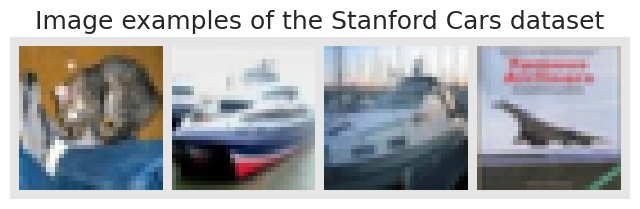

In [9]:
NUM_IMAGES = 4
CIFAR_images = torch.stack([test_dset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()

sns.set(style="whitegrid", context="talk", palette="rainbow")

plt.figure(figsize=(8, 8))
plt.title("Image examples of the Stanford Cars dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

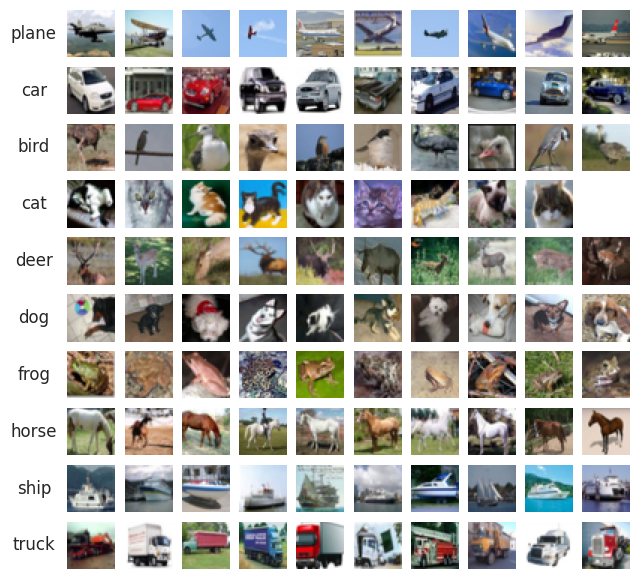

In [11]:
def collate(batch):
    images, labels = zip(*batch)
    images = [np.array(img) for img in images]
    images = np.array(images)
    labels = torch.tensor(labels)
    return torch.tensor(images).permute(0, 3, 1, 2), labels

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, collate_fn=collate)

def imshow(img):
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)

class_images = {class_label: [] for class_label in range(10)}
for img, label in zip(images, labels):
    if len(class_images[label.item()]) < 10:
        class_images[label.item()].append(img.numpy())

plt.figure(figsize=(8,8))
sns.set_style('white')

for class_idx, class_label in enumerate(classes):
    plt.subplot(11, 11, class_idx * 11 + 1)
    plt.text(0.5, 0.5, class_label, ha='center', va='center', fontsize=12)
    plt.axis('off')

for class_idx, (class_label, img_list) in enumerate(class_images.items()):
    for img_num, img in enumerate(img_list):
        plt.subplot(11, 11, class_idx * 11 + img_num + 2)
        imshow(img)
plt.show()

In [12]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

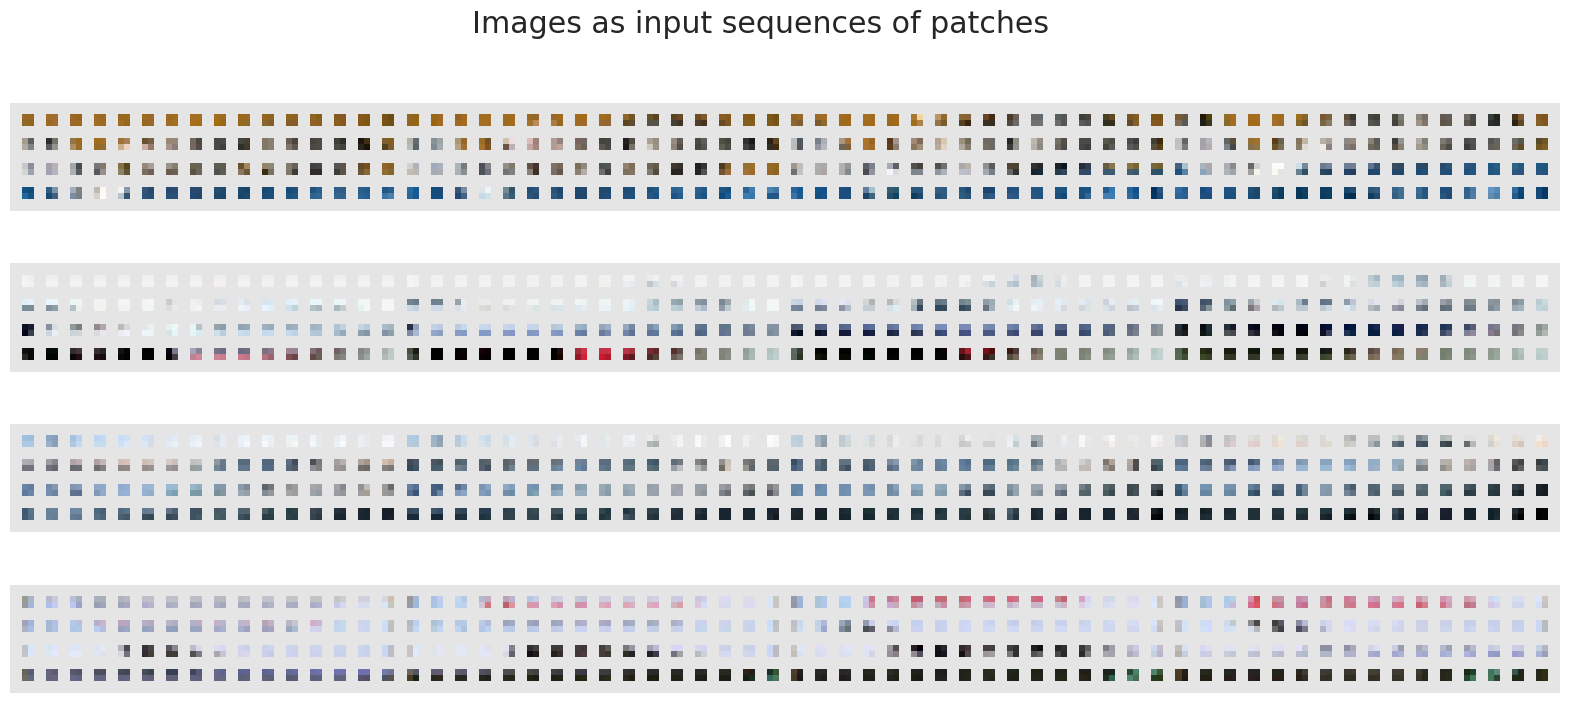

In [14]:
img_patches = img_to_patch(CIFAR_images, patch_size=2, flatten_channels=False)

sns.set(style="whitegrid", context="talk", palette="rainbow")

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(20, 8))
fig.suptitle("Images as input sequences of patches")

for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0).numpy()

    ax[i].imshow(img_grid)
    ax[i].axis("off")

plt.show()
plt.close()

Image size: 32 X 32
Patch size: 2 X 2
Patches per image: 256
Elements per patch: 2


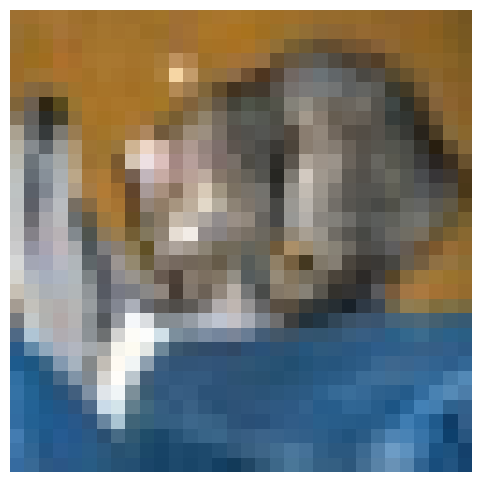

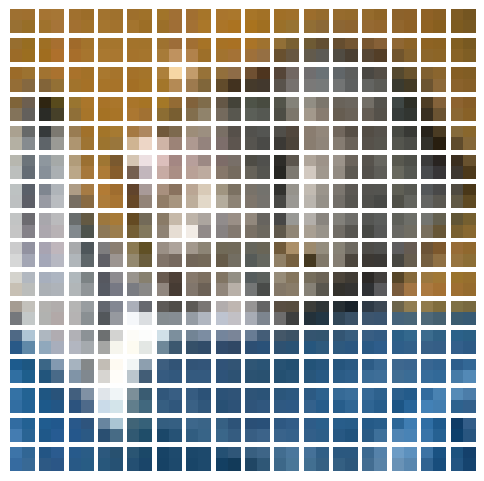

In [17]:
class Patches(nn.Module):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        batch_size, channels, height, width = images.size()
        patches = images.unfold(1, 3, 3).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, -1, 3, self.patch_size, self.patch_size)
        return patches

dataiter = iter(test_loader)
images, labels = next(dataiter)
image = images[0]

class Config:
    image_size = 32
    patch_size = 2

plt.figure(figsize=(6, 6))
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis("off")

resized_image = torch.nn.functional.interpolate(image.unsqueeze(0), size=(Config.image_size, Config.image_size), mode='nearest')
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patch.permute(1, 2, 0).numpy()
    plt.imshow(patch_img)
    plt.axis("off")

plt.show()

## ResNet Model

In [107]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.SiLU(inplace=True))
        super().__init__(*layers)

In [108]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels, act=False),
            nn.Dropout2d(p_drop)
        )

In [109]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = BasicResidual(in_channels, out_channels, p_drop)
        self.act = nn.SiLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)

    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [110]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, repetitions, strides, p_drop=0.):
        layers = []
        out_channels = in_channels
        for rep, stride in zip(repetitions, strides):
            if stride > 1: layers.append(nn.MaxPool2d(stride))
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, out_channels, p_drop))
                in_channels = out_channels
            out_channels *= 2
        super().__init__(*layers)

In [111]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = []
        for out_channels in channel_list:
            layers.append(ConvBlock(in_channels, out_channels, 3, stride=stride))
            in_channels = out_channels
            stride = 1
        super().__init__(*layers)

In [112]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [113]:
class ResNet(nn.Sequential):
    def __init__(self, classes, repetitions, strides=None, in_channels=3, res_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(in_channels, [32, 32, 64], strides[0]),
            ResidualStack(64, repetitions, strides[1:], res_p_drop),
            Head(64 * 2**(len(repetitions) - 1), classes, head_p_drop)
        )

In [114]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [115]:
model = ResNet(args.num_classes, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], res_p_drop=0., head_p_drop=0.3)
model.apply(init_linear)
model.to(DEVICE)

ResNet(
  (0): Stem(
    (0): ConvBlock(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): ConvBlock(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (2): ConvBlock(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
  )
  (1): ResidualStack(
    (0): ResidualBlock(
      (shortcut): Identity()
      (residual): BasicResidual(
        (0): ConvBlock(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, m

### Flop Analysis

In [116]:
from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis, flop_count_table

import warnings
warnings.filterwarnings("ignore")

if __name__ == "__main__":
    model = ResNet(args.num_classes, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], res_p_drop=0., head_p_drop=0.3).to(DEVICE)
    model.eval()
    inputs = torch.randn(1, 3, 32, 32).to(DEVICE)
    model(inputs)

    flops = FlopCountAnalysis(model, inputs)
    param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    acts = ActivationCountAnalysis(model, inputs)

    print(f"total flops : {flops.total()}")
    print(f"total activations: {acts.total()}")
    print(f"number of parameter: {param}")

    print(flop_count_table(flops, max_depth=1))

total flops : 584217600
total activations: 679946
number of parameter: 11200882
| module   | #parameters or shape   | #flops   |
|:---------|:-----------------------|:---------|
| model    | 11.201M                | 0.584G   |
|  0       |  28.768K               |  29.458M |
|  1       |  11.167M               |  0.555G  |
|  2       |  5.13K                 |  13.312K |


### Training

#### Cutmix

In [117]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [118]:
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()

    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)

        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)

        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]

        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y

    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)

        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))

    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

#### Look-Ahead Optimizer

In [119]:
class Lookahead(optim.Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        if not isinstance(optimizer, optim.Optimizer):
            raise ValueError("optimizer must be an instance of torch.optim.Optimizer")

        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state

        for group in self.param_groups:
            group["counter"] = 0

    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)

    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super().load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

In [120]:
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [121]:
def build_scheduler(args, optimizer, n_iter_per_epoch):
    num_steps = int(args.epochs * n_iter_per_epoch)

    lr_scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=50, cycle_mult=1,
                                                                    max_lr=args.lr, min_lr=args.min_lr, warmup_steps=args.warmup_epochs,
                                                                    gamma=args.gamma)
    return lr_scheduler

In [122]:
base_optimizer = optim.AdamW(model.parameters(), lr=args.min_lr, weight_decay=args.weight_decay)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)
loss = nn.CrossEntropyLoss(label_smoothing=args.label_smoothing)
lr_scheduler = build_scheduler(args, optimizer, len(train_loader))
cutmix = CutMix(loss, α=0.5)

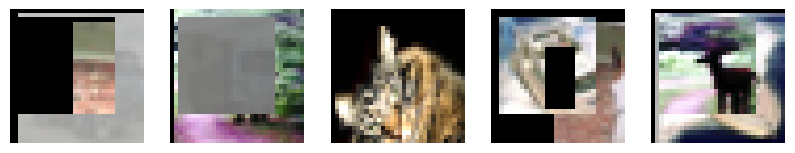

In [66]:
def plot_cutmix_images(model, data_loader, device):

    images, labels = next(iter(data_loader))
    mixed_images, _ = model.prepare_batch((images, labels), device=DEVICE, non_blocking=True)
    np_images = mixed_images.cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        # Transpose the image from (C, H, W) to (H, W, C) and normalize
        img = np.transpose(np_images[i], (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img)
        ax.axis('off')
    plt.show()

cutmix_model = CutMix(loss = loss, α = 0.5)
cifar10_loader = torch.utils.data.DataLoader(train_dset, batch_size=5, shuffle=True,
                                           num_workers=args.num_workers, pin_memory=True)

plot_cutmix_images(cutmix_model, cifar10_loader, device=DEVICE)

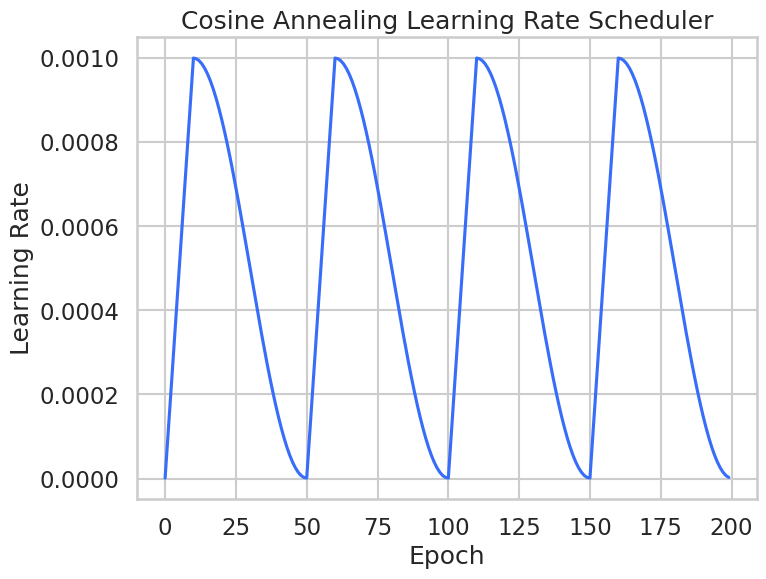

In [67]:
lrs = []
for epoch in range(200):
    lr_scheduler.step(epoch)
    lrs.append(lr_scheduler.get_lr())

plt.figure(figsize=(8,6))
plt.plot(lrs)
plt.title('Cosine Annealing Learning Rate Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [123]:
print(optimizer)

Lookahead (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    counter: 0
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 1e-06
    lr: 1e-06
    maximize: False
    weight_decay: 0.1
)


In [124]:
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step())

ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

pbar = ProgressBar()
pbar.attach(trainer)

history = defaultdict(list)

In [125]:
@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    current_lr = lr_scheduler.get_lr()
    print(f"Learning rate updated to: {current_lr}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)

    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)

    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [126]:
import time

start_time = time.time()

trainer.run(train_loader, max_epochs=args.epochs)

end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time} seconds")

[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009755527298894294]
1/100 - train: loss 1.996; val: loss 1.601 accuracy 0.496


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005786390152875954]
2/100 - train: loss 1.911; val: loss 1.362 accuracy 0.619


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [9.639601130971382e-05]
3/100 - train: loss 1.802; val: loss 1.186 accuracy 0.704


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006004000000000002]
4/100 - train: loss 1.816; val: loss 1.115 accuracy 0.737


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008536998372026805]
5/100 - train: loss 1.789; val: loss 1.216 accuracy 0.687


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0003461460113097139]
6/100 - train: loss 1.722; val: loss 1.044 accuracy 0.774


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [7.149673872728739e-06]
7/100 - train: loss 1.773; val: loss 1.004 accuracy 0.805


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009938503261272714]
8/100 - train: loss 1.724; val: loss 1.021 accuracy 0.790


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006548539886902864]
9/100 - train: loss 1.638; val: loss 0.967 accuracy 0.809


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00014730016279731955]
10/100 - train: loss 1.680; val: loss 0.956 accuracy 0.820


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0004006000000000001]
11/100 - train: loss 1.676; val: loss 0.931 accuracy 0.836


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009046039886902864]
12/100 - train: loss 1.681; val: loss 0.947 accuracy 0.831


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00042236098471240487]
13/100 - train: loss 1.655; val: loss 0.907 accuracy 0.850


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [2.5447270110570814e-05]
14/100 - train: loss 1.684; val: loss 0.906 accuracy 0.845


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.001]
15/100 - train: loss 1.613; val: loss 0.904 accuracy 0.847


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007272682546199037]
16/100 - train: loss 1.656; val: loss 0.894 accuracy 0.846


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020690126647990973]
17/100 - train: loss 1.610; val: loss 0.884 accuracy 0.854


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020080000000000003]
18/100 - train: loss 1.592; val: loss 0.858 accuracy 0.862


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009455577588320898]
19/100 - train: loss 1.588; val: loss 0.864 accuracy 0.854


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005005000000000001]
20/100 - train: loss 1.650; val: loss 0.942 accuracy 0.837


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [5.544224116791029e-05]
21/100 - train: loss 1.616; val: loss 0.868 accuracy 0.861


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008002000000000002]
22/100 - train: loss 1.576; val: loss 0.831 accuracy 0.875


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007940987335200904]
23/100 - train: loss 1.628; val: loss 0.867 accuracy 0.857


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00027373174538009644]
24/100 - train: loss 1.630; val: loss 0.874 accuracy 0.867


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [1e-06]
25/100 - train: loss 1.586; val: loss 0.837 accuracy 0.876


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009755527298894294]
26/100 - train: loss 1.582; val: loss 0.929 accuracy 0.831


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005786390152875954]
27/100 - train: loss 1.558; val: loss 0.845 accuracy 0.876


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [9.639601130971382e-05]
28/100 - train: loss 1.632; val: loss 0.863 accuracy 0.876


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006004000000000002]
29/100 - train: loss 1.555; val: loss 0.814 accuracy 0.883


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008536998372026805]
30/100 - train: loss 1.605; val: loss 0.897 accuracy 0.847


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0003461460113097139]
31/100 - train: loss 1.574; val: loss 0.833 accuracy 0.883


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [7.149673872728739e-06]
32/100 - train: loss 1.530; val: loss 0.810 accuracy 0.881


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009938503261272714]
33/100 - train: loss 1.622; val: loss 0.941 accuracy 0.839


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006548539886902864]
34/100 - train: loss 1.545; val: loss 0.852 accuracy 0.871


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00014730016279731955]
35/100 - train: loss 1.562; val: loss 0.811 accuracy 0.888


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0004006000000000001]
36/100 - train: loss 1.593; val: loss 0.821 accuracy 0.887


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009046039886902864]
37/100 - train: loss 1.551; val: loss 0.817 accuracy 0.878


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00042236098471240487]
38/100 - train: loss 1.515; val: loss 0.858 accuracy 0.853


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [2.5447270110570814e-05]
39/100 - train: loss 1.557; val: loss 0.813 accuracy 0.888


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.001]
40/100 - train: loss 1.581; val: loss 0.873 accuracy 0.865


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007272682546199037]
41/100 - train: loss 1.534; val: loss 0.848 accuracy 0.878


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020690126647990973]
42/100 - train: loss 1.566; val: loss 0.810 accuracy 0.885


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020080000000000003]
43/100 - train: loss 1.588; val: loss 0.812 accuracy 0.897


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009455577588320898]
44/100 - train: loss 1.563; val: loss 0.841 accuracy 0.878


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005005000000000001]
45/100 - train: loss 1.544; val: loss 0.824 accuracy 0.875


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [5.544224116791029e-05]
46/100 - train: loss 1.554; val: loss 0.804 accuracy 0.888


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008002000000000002]
47/100 - train: loss 1.592; val: loss 0.808 accuracy 0.894


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007940987335200904]
48/100 - train: loss 1.515; val: loss 0.902 accuracy 0.843


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00027373174538009644]
49/100 - train: loss 1.554; val: loss 0.813 accuracy 0.887


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [1e-06]
50/100 - train: loss 1.513; val: loss 0.800 accuracy 0.891


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009755527298894294]
51/100 - train: loss 1.561; val: loss 0.864 accuracy 0.864


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005786390152875954]
52/100 - train: loss 1.566; val: loss 0.828 accuracy 0.891


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [9.639601130971382e-05]
53/100 - train: loss 1.582; val: loss 0.817 accuracy 0.892


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006004000000000002]
54/100 - train: loss 1.537; val: loss 0.785 accuracy 0.895


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008536998372026805]
55/100 - train: loss 1.588; val: loss 0.931 accuracy 0.839


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0003461460113097139]
56/100 - train: loss 1.565; val: loss 0.823 accuracy 0.885


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [7.149673872728739e-06]
57/100 - train: loss 1.565; val: loss 0.799 accuracy 0.900


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009938503261272714]
58/100 - train: loss 1.491; val: loss 0.837 accuracy 0.867


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006548539886902864]
59/100 - train: loss 1.546; val: loss 0.818 accuracy 0.883


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00014730016279731955]
60/100 - train: loss 1.529; val: loss 0.819 accuracy 0.890


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0004006000000000001]
61/100 - train: loss 1.512; val: loss 0.791 accuracy 0.897


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009046039886902864]
62/100 - train: loss 1.527; val: loss 0.804 accuracy 0.886


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00042236098471240487]
63/100 - train: loss 1.531; val: loss 0.840 accuracy 0.879


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [2.5447270110570814e-05]
64/100 - train: loss 1.532; val: loss 0.779 accuracy 0.898


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.001]
65/100 - train: loss 1.502; val: loss 0.836 accuracy 0.877


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007272682546199037]
66/100 - train: loss 1.502; val: loss 0.830 accuracy 0.875


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020690126647990973]
67/100 - train: loss 1.503; val: loss 0.766 accuracy 0.899


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020080000000000003]
68/100 - train: loss 1.483; val: loss 0.762 accuracy 0.900


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009455577588320898]
69/100 - train: loss 1.503; val: loss 0.792 accuracy 0.891


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005005000000000001]
70/100 - train: loss 1.542; val: loss 0.800 accuracy 0.886


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [5.544224116791029e-05]
71/100 - train: loss 1.536; val: loss 0.772 accuracy 0.903


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008002000000000002]
72/100 - train: loss 1.519; val: loss 0.792 accuracy 0.895


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007940987335200904]
73/100 - train: loss 1.529; val: loss 0.845 accuracy 0.873


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00027373174538009644]
74/100 - train: loss 1.539; val: loss 0.778 accuracy 0.900


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [1e-06]
75/100 - train: loss 1.568; val: loss 0.790 accuracy 0.895


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009755527298894294]
76/100 - train: loss 1.525; val: loss 0.846 accuracy 0.871


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005786390152875954]
77/100 - train: loss 1.526; val: loss 0.799 accuracy 0.897


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [9.639601130971382e-05]
78/100 - train: loss 1.494; val: loss 0.778 accuracy 0.898


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006004000000000002]
79/100 - train: loss 1.555; val: loss 0.807 accuracy 0.896


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008536998372026805]
80/100 - train: loss 1.526; val: loss 0.815 accuracy 0.892


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0003461460113097139]
81/100 - train: loss 1.491; val: loss 0.806 accuracy 0.888


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [7.149673872728739e-06]
82/100 - train: loss 1.538; val: loss 0.765 accuracy 0.903


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009938503261272714]
83/100 - train: loss 1.534; val: loss 0.887 accuracy 0.848


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0006548539886902864]
84/100 - train: loss 1.535; val: loss 0.833 accuracy 0.889


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00014730016279731955]
85/100 - train: loss 1.558; val: loss 0.784 accuracy 0.900


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0004006000000000001]
86/100 - train: loss 1.521; val: loss 0.764 accuracy 0.902


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009046039886902864]
87/100 - train: loss 1.546; val: loss 0.799 accuracy 0.889


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00042236098471240487]
88/100 - train: loss 1.551; val: loss 0.845 accuracy 0.877


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [2.5447270110570814e-05]
89/100 - train: loss 1.499; val: loss 0.771 accuracy 0.900


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.001]
90/100 - train: loss 1.547; val: loss 0.807 accuracy 0.896


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007272682546199037]
91/100 - train: loss 1.525; val: loss 0.847 accuracy 0.876


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020690126647990973]
92/100 - train: loss 1.555; val: loss 0.805 accuracy 0.892


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00020080000000000003]
93/100 - train: loss 1.561; val: loss 0.793 accuracy 0.902


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0009455577588320898]
94/100 - train: loss 1.509; val: loss 0.778 accuracy 0.900


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0005005000000000001]
95/100 - train: loss 1.522; val: loss 0.809 accuracy 0.891


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [5.544224116791029e-05]
96/100 - train: loss 1.506; val: loss 0.779 accuracy 0.899


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0008002000000000002]
97/100 - train: loss 1.517; val: loss 0.770 accuracy 0.904


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.0007940987335200904]
98/100 - train: loss 1.506; val: loss 0.854 accuracy 0.871


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [0.00027373174538009644]
99/100 - train: loss 1.556; val: loss 0.812 accuracy 0.888


[1/1563]   0%|           [00:00<?]

Learning rate updated to: [1e-06]
100/100 - train: loss 1.463; val: loss 0.744 accuracy 0.907
Training time: 4101.146918773651 seconds


### Train and Validation Loss

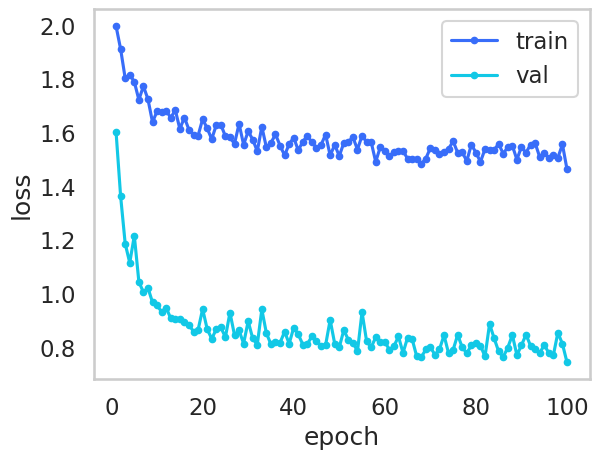

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

### Validation Accuracy

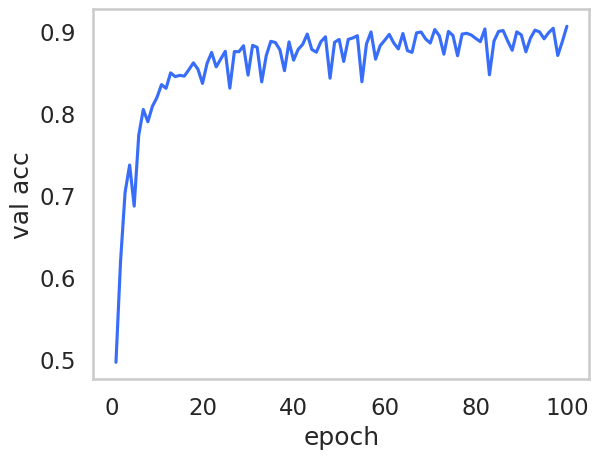

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()